In [2]:
!pip install -r requirements.txt

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import torch
import torchvision
import torchvision.transforms as transforms
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from quant_optimizer import no_quant, quantizationSGD
from bfp_quantize import bfp_quantize, round_fp16

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
# PyTorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    


In [19]:

model = GarmentClassifier()


transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
#uncomment this line to make training data set smaller
# training_set = torch.utils.data.Subset(training_set, range(5000))
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

# print(training_set[0][0].shape)

loss_fn = torch.nn.CrossEntropyLoss()

# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scale_factor = 1
# optimizer = quantizationSGD(optimizer, grad_scaling = scale_factor)

optimizer = quantizationSGD(optimizer,weight_quant=bfp_quantize, grad_quant=bfp_quantize, momentum_quant=bfp_quantize, grad_scaling = scale_factor)



def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels) * (1/scale_factor)
        loss.backward()

     
        # Adjust learning weights
        optimizer.step(i=i)
        
        loss = loss * (scale_factor)

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 10

best_vloss = 1_000_000.

total_samples = len(validation_set)
correct_samples = 0


Training set has 60000 instances
Validation set has 10000 instances


In [20]:
val_loss = []
train_loss = []
for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss
            if(epoch == EPOCHS -1):
                  _, pred = torch.max(voutputs, dim=1)
                  correct_samples += pred.eq(vlabels).sum()

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    train_loss.append(avg_loss)
    val_loss.append(avg_vloss)
    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1
print(f'Val Accuracy: {correct_samples/total_samples}')

EPOCH 1:
  batch 1000 loss: 1.7514209411144257
  batch 2000 loss: 0.9313448480218649
  batch 3000 loss: 0.7987236887644976
  batch 4000 loss: 0.7203740104502067
  batch 5000 loss: 0.6984116430925206
  batch 6000 loss: 0.6221937581235543
  batch 7000 loss: 0.6066572653071489
  batch 8000 loss: 0.6369229039829224
  batch 9000 loss: 0.5725811019865796
  batch 10000 loss: 0.559255063761957
  batch 11000 loss: 0.5600349847378675
  batch 12000 loss: 0.5217087847336661
  batch 13000 loss: 0.514983381491853
  batch 14000 loss: 0.5166786890011281
  batch 15000 loss: 0.4999520194280194
LOSS train 0.4999520194280194 valid 0.5057547092437744
EPOCH 2:
  batch 1000 loss: 0.48651450563874094
  batch 2000 loss: 0.4615942431264557
  batch 3000 loss: 0.4746118849683553
  batch 4000 loss: 0.4642419992474606
  batch 5000 loss: 0.4717033745080698
  batch 6000 loss: 0.4534662053789361
  batch 7000 loss: 0.4725150564336218
  batch 8000 loss: 0.45706538747251035
  batch 9000 loss: 0.44275422964966854
  batch 

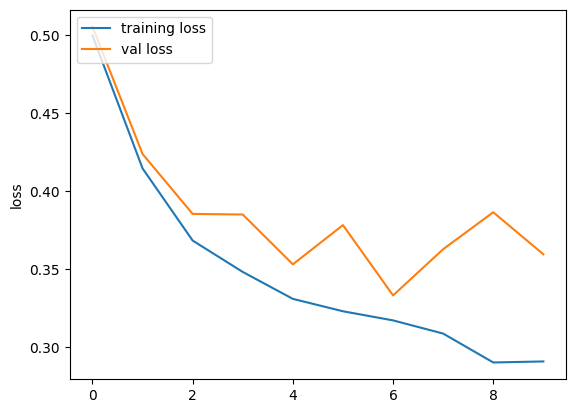

In [21]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label = 'training loss')
plt.plot(val_loss, label = "val loss")
plt.legend(loc="upper left")
plt.ylabel('loss')
plt.show()